<a href="https://colab.research.google.com/github/BenxiaHu/Python/blob/master/Stripe_HiC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Mathematical Foundation of Stripe Analysis
What is a “stripe”?
In a Hi-C contact map (which is usually represented as a 2D matrix
𝑀 of contact counts), a “stripe” often appears as a continuous band of high interaction values radiating from a particular anchor point (often a genomic boundary, like a CTCF site). These stripes may extend diagonally (if one reorients the matrix), or more simply, you can see them as a horizontal or vertical band of enriched interactions.

Formally, for a matrix
𝑀 where 𝑀𝑖,𝑗 represents the observed contact frequency between genomic bins 𝑖 and 𝑗:
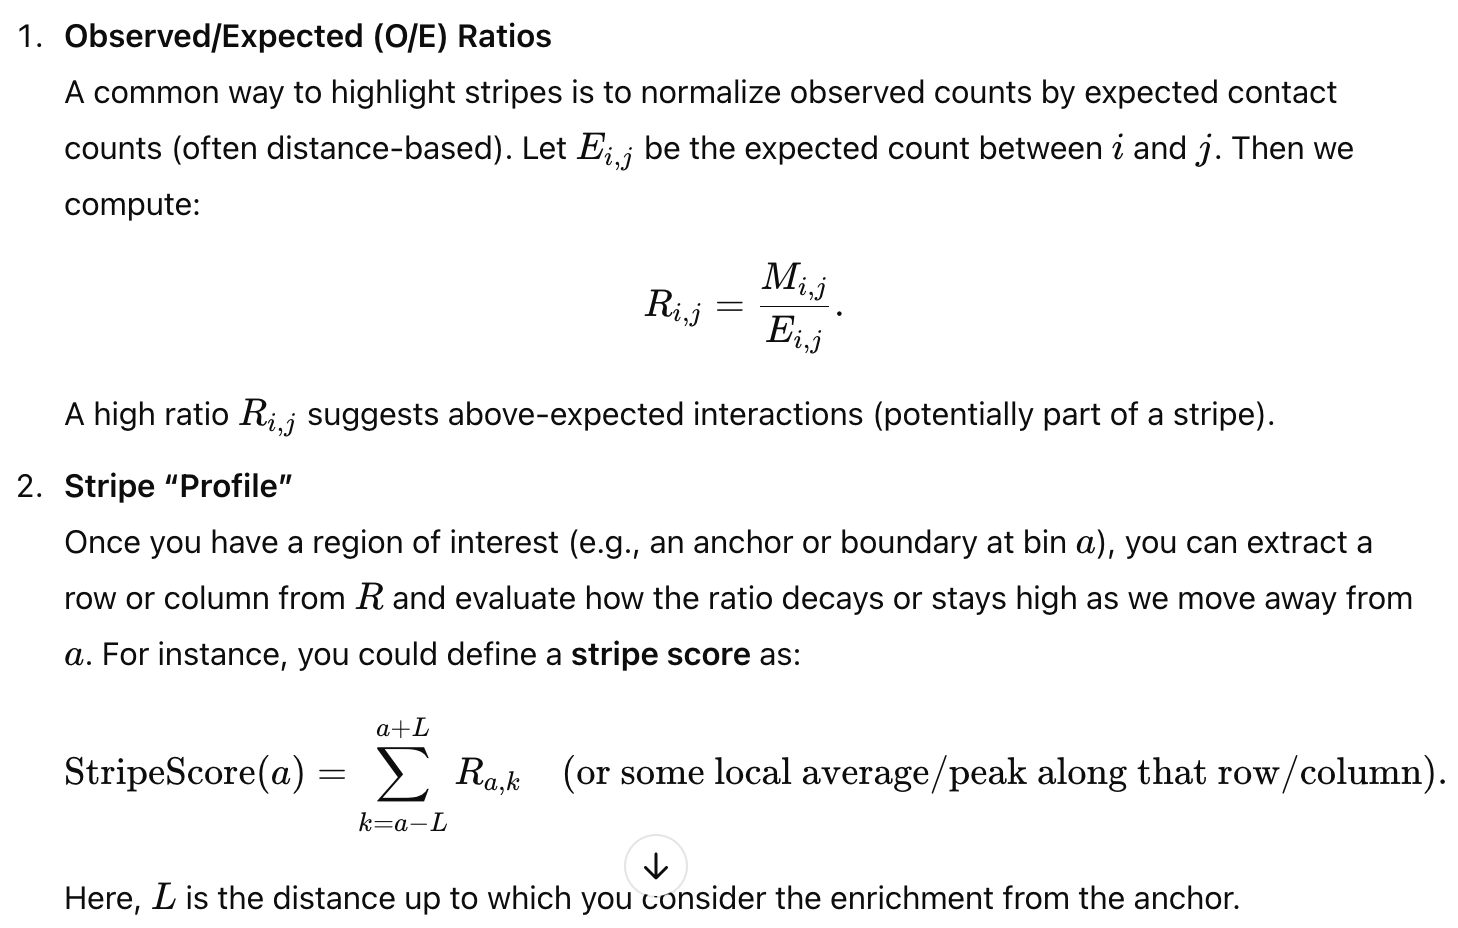

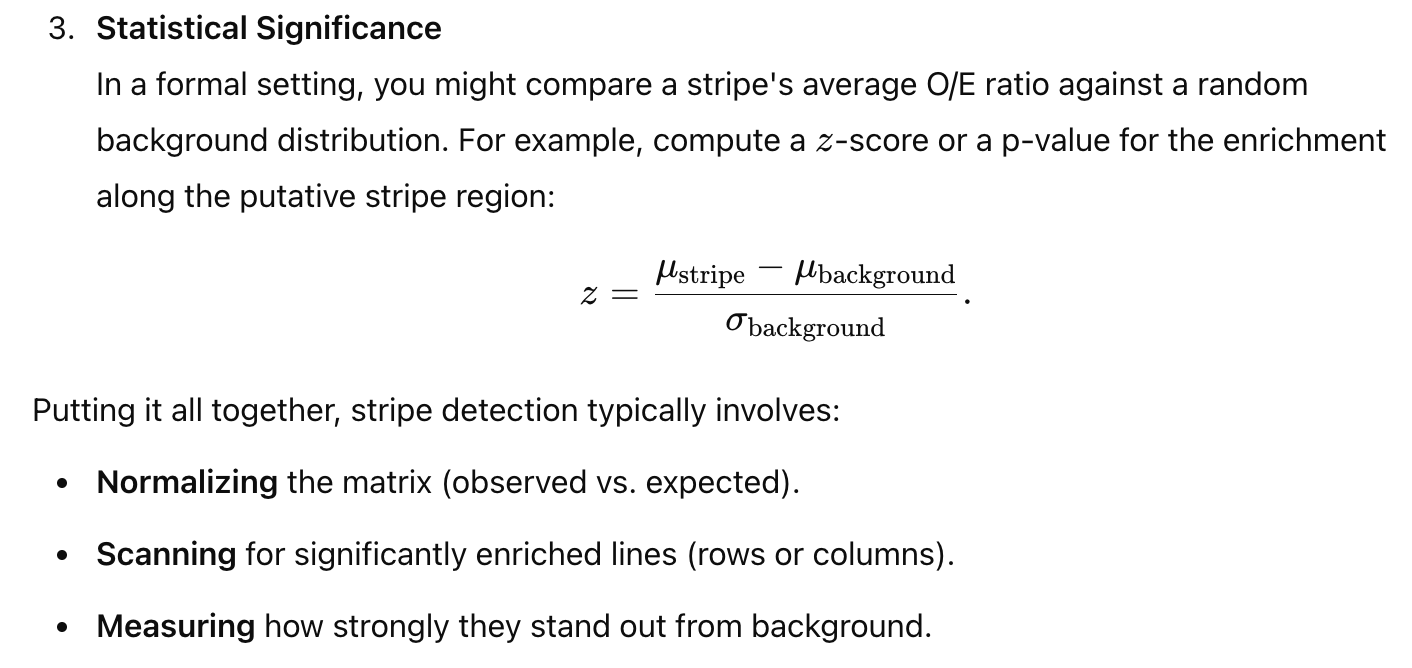

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1. Simulate a Hi-C Contact Matrix (M)

In [2]:
N = 1000  # number of bins
np.random.seed(42)  # for reproducibility

# Generate a random matrix
M_raw = np.random.poisson(lam=50, size=(N, N)).astype(float)
# Make it symmetric to mimic real Hi-C contact matrices
M_raw = 0.5 * (M_raw + M_raw.T)

# 2. Compute the Observed/Expected (O/E) Matrix

In [3]:
diag_sums = np.zeros(N)
diag_counts = np.zeros(N)
for i in range(N):
    for j in range(N):
        d = abs(i - j)
        diag_sums[d] += M_raw[i, j]
        diag_counts[d] += 1

diag_avgs = diag_sums / diag_counts

hic_matrix = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        d = abs(i - j)
        expected = diag_avgs[d]
        if expected == 0:
            hic_matrix[i, j] = 0
        else:
            hic_matrix[i, j] = M_raw[i, j] / expected

# 3. Stripe Score Computation


In [9]:
def compute_stripe_scores(R, window=3):
    """
    For each row i in R, we find the *maximum local sum*
    within a +/- window. This maximum local sum is the
    row's 'stripe score'.
    (We use prefix sums for efficiency.)

    Returns:
       row_scores: list of length n, row_scores[i] is the
                   best (maximum) local sum in row i.
    """
    n = len(R)
    row_scores = [0.0]*n

    for i in range(n):
        row_i = R[i]

        # Build a prefix sum array P, so that:
        # P[k] = sum of row_i[0..k-1], with P[0] = 0
        P = [0.0]*(n+1)
        for k in range(1, n+1):
            P[k] = P[k-1] + row_i[k-1]

        # Slide across row i, compute local sum in [j-window, j+window]
        # and keep track of the maximum sum found
        best_sum = 0.0
        for j in range(n):
            left = max(0, j - window)
            right = min(n, j + window + 1)
            window_sum = P[right] - P[left]
            if window_sum > best_sum:
                best_sum = window_sum

        row_scores[i] = best_sum

    return row_scores

#  'window=3' means we look +/- 3 bins for local sums
n = len(hic_matrix)
scores = compute_stripe_scores(hic_matrix, window=3)

# 7. PLOT RESULTS

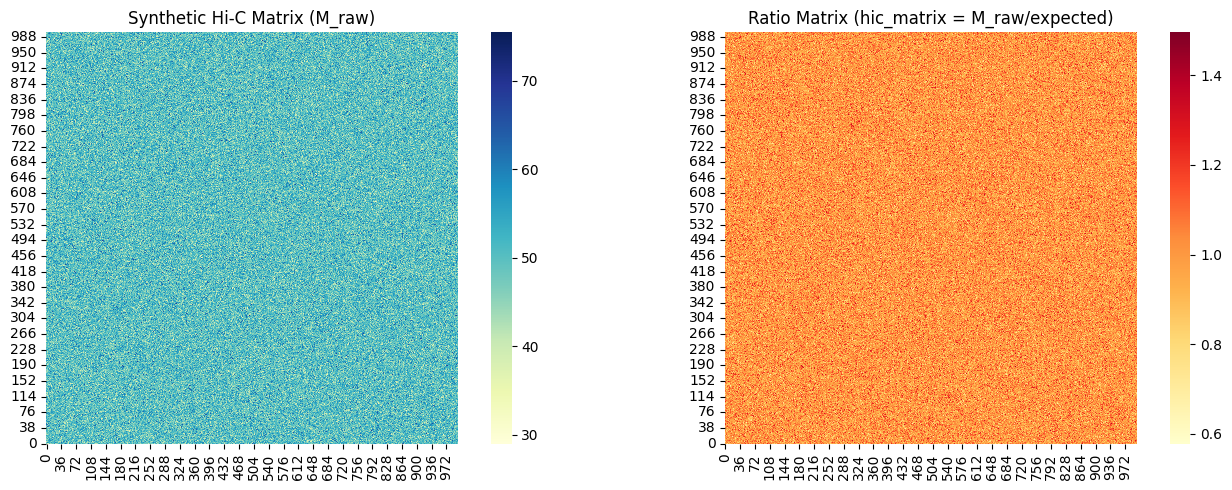

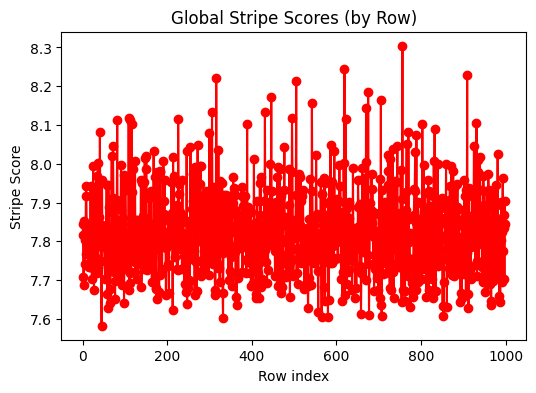

In [10]:
# (D) Plot the raw matrix and ratio matrix
fig, axs = plt.subplots(1, 2, figsize=(14,5))

sns.heatmap(M_raw, ax=axs[0], cmap='YlGnBu', square=True)
axs[0].set_title("Synthetic Hi-C Matrix (M_raw)")
axs[0].invert_yaxis()

sns.heatmap(hic_matrix, ax=axs[1], cmap='YlOrRd', square=True)
axs[1].set_title("Ratio Matrix (hic_matrix = M_raw/expected)")
axs[1].invert_yaxis()

plt.tight_layout()
plt.show()

# (E) Plot the global stripe scores
plt.figure(figsize=(6,4))
plt.plot(range(n), scores, marker='o', linestyle='-', color='red')
plt.title("Global Stripe Scores (by Row)")
plt.xlabel("Row index")
plt.ylabel("Stripe Score")
plt.show()